In [1]:
#John Gizis
#Plot parallax observations for a given LSST simulation. adopted from Peter Yoachim's code at https://github.com/yoachim/LSST-BD-Cadence/blob/main/Pass_example.ipynb

#note this uses rubin_sim 

In [2]:

import rubin_sim.maf.utils as mafUtils

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import rubin_sim.maf.db as db
import rubin_sim.maf.utils as utils
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf.slicers as slicers
import rubin_sim.maf.metricBundles as metricBundles
import rubin_sim.maf.plots as plots
import rubin_sim.maf.maps as maps


In [3]:
#choose location for plotting

#random spot in main survery
ra0=0
dec0=-20

# ...or...
#ra0=9.45
#dec0= -44
#This is a deep drilling field!

In [4]:
dbFile = '/sims_maf/fbs_2.0/presto/presto_gap4.0_mix_v2.0_10yrs.db' 
runName = dbFile.replace('.db', '')
conn = db.OpsimDatabase(dbFile)
outDir='illustrate'
resultsDb = db.ResultsDb(outDir=outDir)

In [5]:
bundleList = []
#sql = 'filter="z" or filter="y"'
sql = 'visitExposureTime > 14.'
metric = metrics.PassMetric(cols=['filter', 'fiveSigmaDepth', 'ra_pi_amp',
                                  'dec_pi_amp', 'seeingFwhmGeom','observationStartMJD'
                                 ])
slicer = slicers.UserPointsSlicer(ra=ra0, dec=dec0)
plotDict = {}
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict,
                                             runName=runName))


In [6]:
bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()

Querying database observations with constraint visitExposureTime > 14. for columns ['rotSkyPos', 'filter', 'fieldRA', 'seeingFwhmGeom', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD']
Found 1991729 visits
Running:  ['_sims_maf_fbs_2_0_presto_presto_gap4_0_mix_v2_0_10yrs_Pass_filter_fiveSigmaDepth_ra_pi_amp_dec_pi_amp_seeingFwhmGeom_observationStartMJD_visitExposureTime_gt_14_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [7]:
bundleList[0].metricValues[0].dtype
dataSlice = bundleList[0].metricValues[0]

In [8]:
dataSlice.dtype


dtype([('rotSkyPos', '<f8'), ('filter', '<U256'), ('fieldRA', '<f8'), ('seeingFwhmGeom', '<f8'), ('fiveSigmaDepth', '<f8'), ('fieldDec', '<f8'), ('observationStartMJD', '<f8'), ('ra_pi_amp', '<f8'), ('dec_pi_amp', '<f8')])

In [9]:
# Here's the parallax amplitude. I'll just assume a 1" parallax star, but could multiply by any factor.
parallax_amplitude = (dataSlice['ra_pi_amp']**2 + dataSlice['dec_pi_amp']**2)**0.5
star_mag = 20.  # Just assume a flat SED. This is used in the estimate of the uncertainty.
snr = parallax_amplitude*0
atm_err = 0.01

for filt in np.unique(dataSlice['filter']):
    good = np.where(dataSlice['filter'] == filt)
    snr[good] = mafUtils.m52snr(star_mag, dataSlice['fiveSigmaDepth'][good])
position_errors = np.sqrt(mafUtils.astrom_precision(dataSlice['seeingFwhmGeom'],
                                                            snr)**2+atm_err**2)

Text(0, 0.5, 'Parallax Amplitude (arcsec)')

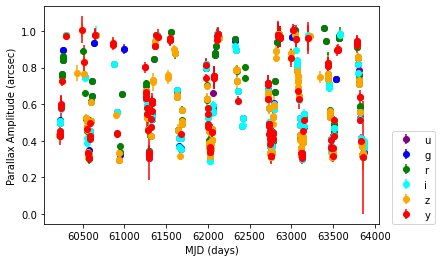

In [10]:
f2c = {'u': 'purple', 'g': 'blue', 'r': 'green',
           'i': 'cyan', 'z': 'orange', 'y': 'red'}

for filt in 'ugrizy':
    good = np.where(dataSlice['filter'] == filt)
    plt.errorbar(dataSlice['observationStartMJD'][good], parallax_amplitude[good], yerr=position_errors[good],
                color=f2c[filt], fmt='o', label=filt)
plt.legend(loc=(1.04,0))
plt.xlabel('MJD (days)')
plt.ylabel('Parallax Amplitude (arcsec)')

In [11]:
izy = np.where((dataSlice['filter'] == 'z')|(dataSlice['filter'] == 'y'))
iz = np.where(dataSlice['filter'] == 'z')
iy = np.where(dataSlice['filter'] == 'y')
            

In [12]:
plot_base = """plot_presto_bad_{plottype}_{ra}_{dec}.{ftype}"""


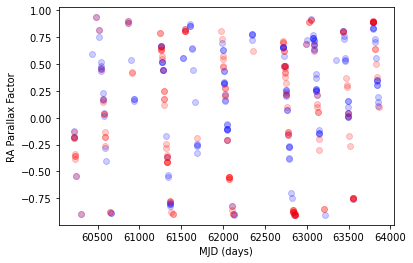

In [13]:
plt.plot(dataSlice['observationStartMJD'][iz],dataSlice['ra_pi_amp'][iz],'o',color='blue',alpha=0.2)
plt.plot(dataSlice['observationStartMJD'][iy],dataSlice['ra_pi_amp'][iy],'o',color='red',alpha=0.2)
plt.xlabel('MJD (days)')
plt.ylabel('RA Parallax Factor')   
plotname=plot_base.format(plottype='MJD_RAP',ra=ra0,dec=dec0,ftype='pdf')
plt.savefig(plotname)

In [14]:
days_since_start = dataSlice['observationStartMJD'] - np.min(dataSlice['observationStartMJD'])
years_since_start = days_since_start / 365.25636        #am I using right length of year? 
phase_years = years_since_start % 1

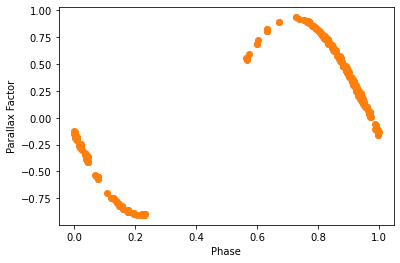

In [15]:
plt.plot(phase_years[izy],dataSlice['ra_pi_amp'][izy],'o',color='C1')
plt.xlabel('Phase')
plt.ylabel('Parallax Factor')   
plotname=plot_base.format(plottype='Phase_PF',ra=ra0,dec=dec0,ftype='pdf')
plt.savefig(plotname)


In [16]:
np.size(dataSlice['ra_pi_amp'][izy])

335

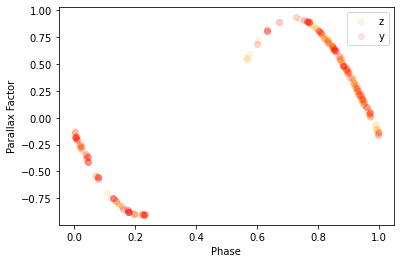

In [17]:
plt.plot(phase_years[iz],dataSlice['ra_pi_amp'][iz],'o',color='blue',alpha=0.1,label='z')
plt.plot(phase_years[iy],dataSlice['ra_pi_amp'][iy],'o',color='red',alpha=0.1,label='y')
plt.xlabel('Phase')
plt.ylabel('Parallax Factor');
plt.legend()
plotname=plot_base.format(plottype='Phase_PF',ra=ra0,dec=dec0,ftype='pdf')
plt.savefig(plotname)



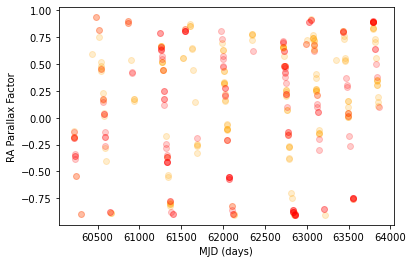

In [18]:
plt.plot(dataSlice['observationStartMJD'][iz],dataSlice['ra_pi_amp'][iz],'o',color='orange',alpha=0.2)
plt.plot(dataSlice['observationStartMJD'][iy],dataSlice['ra_pi_amp'][iy],'o',color='red',alpha=0.2)
plt.xlabel('MJD (days)')
plt.ylabel('RA Parallax Factor')  
plotname=plot_base.format(plottype='MJD_RAP_zy',ra=ra0,dec=dec0,ftype='pdf')
plt.savefig(plotname)




In [19]:
print(np.max(dataSlice['ra_pi_amp'][iy]),np.min(dataSlice['ra_pi_amp'][iy]))

0.9363656088271664 -0.9040635870864173


In [20]:
from astropy.table import QTable, Table, Column
from astropy import units as u

In [21]:
parallax_table = Table()
parallax_table['MJD'] = dataSlice['observationStartMJD'][izy]
parallax_table['ra_pi_amp'] = dataSlice['ra_pi_amp'][izy]
parallax_table['dec_pi_amp'] = dataSlice['dec_pi_amp'][izy]
parallax_table['filter'] = dataSlice['filter'][izy]
parallax_table['seeingFWHM'] = dataSlice['seeingFwhmGeom'][izy]
parallax_table['snr'] = snr[izy]
parallax_table['position_errors'] = position_errors[izy]
parallax_table['fiveSigmaDepth'] = dataSlice['fiveSigmaDepth'][izy]
parallax_table['fieldRA'] = dataSlice['fieldRA'][izy]
parallax_table['fieldDec'] = dataSlice['fieldDec'][izy]




In [22]:
parallax_table

MJD,ra_pi_amp,dec_pi_amp,filter,seeingFWHM,snr,position_errors,fiveSigmaDepth,fieldRA,fieldDec
float64,float64,float64,str256,float64,float64,float64,float64,float64,float64
61974.225029973226,0.8046858302529718,0.13842212810505963,y,0.9414754736183094,28.248949510533148,0.03479572630811676,21.880080745189183,359.0217534582348,-21.3618501583812
63115.31510803293,0.2621459546002791,-0.2467076812481766,z,0.8236589267137848,69.86570331640067,0.015459127448561498,22.863235077460544,359.70017682831934,-21.54613988000481
63496.28436621698,0.015566224298006501,-0.36084197779202964,y,0.829755180485654,29.00830005147158,0.030301688045532398,21.908880686563258,359.4788658335433,-21.78492210005766
62130.053439115625,-0.8995680434252902,-0.33605621049339734,z,1.0406619615777606,49.26103526806392,0.023372740563065812,22.48383382594867,359.20705027929614,-21.334791916459565
63087.191376974166,0.6428510077155464,-0.010922195511720235,z,1.163262607141262,49.35644799165527,0.025602326510654617,22.485934732954135,359.8218543695684,-21.654001368010974
63088.19401163235,0.6253919206898685,-0.020227110679129825,y,1.2049278247736586,23.010813868146652,0.05330985851357954,21.6574049378518,359.3600365901218,-21.55590219327928
60930.34836388096,0.1588251394256118,-0.2898311190590487,z,0.9531680213828371,55.093164855066846,0.01998312637563311,22.60531929255704,359.1722950672917,-21.33617916453522
62720.436431744674,0.6524128235872406,0.0032364345524371727,z,0.9274132052210898,40.11772834896351,0.025187479997359263,22.26091582237379,359.2244606730128,-21.364489846333843
63496.08696062294,0.018670993017377405,-0.359595577621749,z,0.8122021957513677,49.27039264805528,0.019280603982825745,22.484040047384482,359.4788658335433,-21.78492210005766


In [23]:
from astropy.io import ascii

In [24]:
out_base = """data_presto_bad_{datatype}_{ra}_{dec}.{ftype}"""
outname_tbl=out_base.format(datatype='parallax',ra=ra0,dec=dec0,ftype='tbl')
outname_csv=out_base.format(datatype='parallax',ra=ra0,dec=dec0,ftype='csv')


In [25]:
#ascii.write(parallax_table,outname_tbl,format='ipac')

In [26]:
ascii.write(parallax_table,outname_csv,format='ecsv')

(array([1.16743135, 0.42157243, 0.03242865, 0.29185784, 0.03242865,
        0.42157243, 0.29185784, 0.61614433, 0.55128703, 0.19457189,
        0.51885838, 0.58371568, 0.74585892, 0.48642973, 0.58371568,
        0.74585892, 0.77828757, 0.81071622, 0.81071622, 0.77828757]),
 array([-0.90464519, -0.81259465, -0.72054411, -0.62849357, -0.53644303,
        -0.44439249, -0.35234195, -0.26029141, -0.16824087, -0.07619033,
         0.01586021,  0.10791075,  0.19996129,  0.29201183,  0.38406237,
         0.47611291,  0.56816345,  0.66021399,  0.75226453,  0.84431507,
         0.93636561]),
 [<matplotlib.patches.Polygon at 0x7faa69fc1700>])

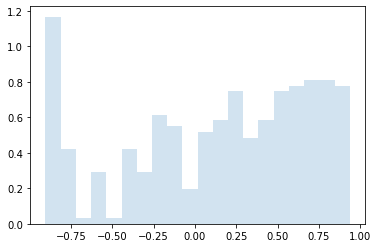

In [27]:
plt.hist(parallax_table['ra_pi_amp'],bins=20,histtype='stepfilled', alpha=0.2, density=True)


(array([0.00172798, 0.01151988, 0.01324787, 0.02649573, 0.03167968,
        0.01439985, 0.0195838 , 0.0201598 , 0.0097919 , 0.00863991,
        0.00863991, 0.00863991, 0.00403196, 0.00633594, 0.00115199,
        0.00115199, 0.00230398, 0.00115199, 0.00115199, 0.00115199]),
 array([  8.78076544,  13.96323908,  19.14571271,  24.32818635,
         29.51065998,  34.69313362,  39.87560725,  45.05808088,
         50.24055452,  55.42302815,  60.60550179,  65.78797542,
         70.97044906,  76.15292269,  81.33539632,  86.51786996,
         91.70034359,  96.88281723, 102.06529086, 107.2477645 ,
        112.43023813]),
 [<matplotlib.patches.Polygon at 0x7faa69f23310>])

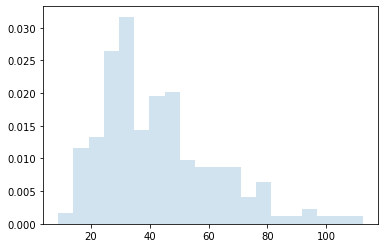

In [28]:
plt.hist(parallax_table['snr'],bins=20,histtype='stepfilled', alpha=0.2, density=True)



(array([0.02156552, 0.        , 0.02156552, 0.04313104, 0.08626209,
        0.28035179, 0.30191731, 0.23722074, 0.58226909, 0.79792431,
        0.86262088, 0.51757253, 0.90575192, 0.6900967 , 0.43131044,
        0.47444148, 0.47444148, 0.23722074, 0.12939313, 0.12939313]),
 array([20.61140593, 20.74982477, 20.88824362, 21.02666246, 21.16508131,
        21.30350015, 21.441919  , 21.58033784, 21.71875668, 21.85717553,
        21.99559437, 22.13401322, 22.27243206, 22.41085091, 22.54926975,
        22.68768859, 22.82610744, 22.96452628, 23.10294513, 23.24136397,
        23.37978282]),
 [<matplotlib.patches.Polygon at 0x7faa69ef7460>])

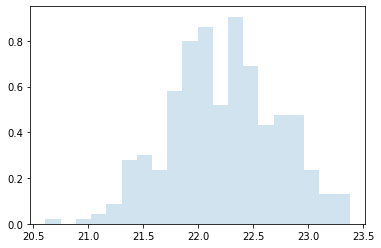

In [29]:
plt.hist(parallax_table['fiveSigmaDepth'],bins=20,histtype='stepfilled', alpha=0.2, density=True)

